### Sample program for Reinforcement Learning with OpenAI Gym and Keras-rl2 

#### Parameters  

In [1]:
max_steps_per_episode = 200
ENV_NAME = 'CartPole-v0'

# List of environments in Gym   
# https://github.com/openai/gym/wiki/Table-of-environments
# https://gym.openai.com/envs/#classic_control

import  os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#### Import libraries  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#### === Scripts to show movement without training ===  

#### Functions to make animation  

In [3]:
def display_frames_as_gif(frames):
    dpi = 200
    fig = plt.figure(figsize=(frames[0].shape[1]/dpi, frames[0].shape[0]/dpi),
                     dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = FuncAnimation(plt.gcf(), animate, frames=len(frames),
                         interval=10, repeat=False)
    print('Saving images into an animation gif file ...')
    anim.save('movie_{}_random.gif'.format(ENV_NAME), writer='pillow')
    print('Done.')
    return anim

#### Random movement  

In [4]:
frames = []
n_trials = 5
env = gym.make(ENV_NAME)

for i in range(n_trials):
    observation = env.reset()  # Reset environment first

    for _ in range(max_steps_per_episode):
        frames.append(env.render(mode='rgb_array'))  # add a snapshot image to frames
        action = np.random.choice(2)  # 0: Push to left, 1: Push to right
        observation, reward, done, info = env.step(action)  # exec an action
    
env.close()

/home/anhvu/miniconda3/envs/ds21/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


#### Save (into gif) and show the movement  

In [5]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

%time an = display_frames_as_gif(frames)
ret = an.to_jshtml()

In [6]:
HTML(ret)  # should be placed in another cell

#### === Scripts to show movement with training ===  

#### Import libraries  

In [7]:
import rl.callbacks
import time

2021-12-15 23:42:02.596380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-15 23:42:02.596402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Class to get animation data during training (learning)  

In [8]:
class ViewLogger(rl.callbacks.Callback):
    def __init__(self):
        self.frames = []

    def on_action_end(self, action, logs):
        self.frames.append(self.env.render(mode='rgb_array'))

    def view(self, interval=5, start_frame=0, end_frame=0):
        assert start_frame<len(self.frames)
        self.start_frame = start_frame
        if end_frame == 0 or end_frame > len(self.frames):
            end_frame = len(self.frames)
        self.t0 = time.time()

        # display sizes
        plt.figure(figsize=(2.5,2.5), dpi=200)

        self.patch = plt.imshow(self.frames[0])
        plt.axis('off')

        anim = FuncAnimation(plt.gcf(), self._plot,
                             frames=end_frame-start_frame, interval=interval,
                             repeat=False)
        print('Saving images into an animation gif file ...')
        anim.save('movie_{}.gif'.format(ENV_NAME), writer='pillow')
        print('Done.')
        return anim.to_jshtml()

    def _plot(self, frame):
        if frame % max_steps_per_episode == 0:
            print("{}f {}m".format(frame, (time.time()-self.t0)/60))
        self.patch.set_data(self.frames[frame+self.start_frame])

#### Reinforcement learning using DQN  

#### Import libraries  

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

#### Parameters  

In [10]:
np.random.seed(111)
env.seed(111)

[111]

In [11]:
env = gym.make(ENV_NAME)
nb_actions = env.action_space.n
nb_observ = env.observation_space.shape
print('Number of dimensions for observation:', nb_observ)
print('Number of dimensions for action:', nb_actions)

Number of dimensions for observation: (4,)
Number of dimensions for action: 2


#### Build a very simple model for reinforcement learning  

In [12]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + nb_observ))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________
None


#### Definition for the Agent by DQN  

In [13]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

/home/anhvu/.local/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-12-15 23:42:05.191304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-15 23:42:05.191342: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-15 23:42:05.191365: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anhvu): /proc/driver/nvidia/version does not exist
2021-12-15 23:42:05.191900: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in othe

#### Execute training (learning)  

In [14]:
%%time

# If visualization is set to True, animation during the training can be seen.
# But this slows down training quite a lot
fit_log = dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)
#fit_log = dqn.fit(env, nb_steps=50000, visualize=True, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 10:32 - reward: 1.0000

/home/anhvu/.local/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/home/anhvu/.local/lib/python3.9/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 79s 8ms/step - reward: 1.0000
103 episodes - episode_reward: 95.350 [10.000, 200.000] - loss: 3.314 - mae: 20.979 - mean_q: 42.483

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 72s 7ms/step - reward: 1.0000
54 episodes - episode_reward: 186.444 [155.000, 200.000] - loss: 3.787 - mae: 39.727 - mean_q: 80.158

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 66s 7ms/step - reward: 1.0000
52 episodes - episode_reward: 194.250 [137.000, 200.000] - loss: 3.027 - mae: 37.772 - mean_q: 75.984

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 69s 7ms/step - reward: 1.0000
50 episodes - episode_reward: 197.760 [147.000, 200.000] - loss: 5.181 - mae: 39.502 - mean_q: 79.394

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 70s 7ms/step - reward: 1.0000
done, took 354.974 seconds
CPU times: user 7min 4s, sys: 32.1 s,

#### Save the final weights  

In [15]:
weight_file = 'dqn_{}_weights.h5f'.format(ENV_NAME)
dqn.save_weights(weight_file, overwrite=True)

#### Show the history of rewards during the training  

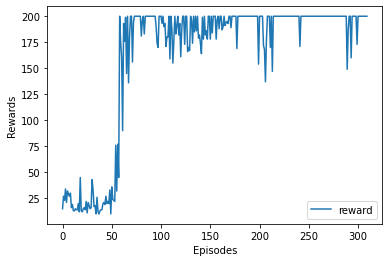

In [16]:
plt.plot(fit_log.history['episode_reward'], label='reward')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

#### Finally, evaluate the model  

In [17]:
%%time

n_trials = 5
view = ViewLogger()
test_log = dqn.test(env, nb_episodes=n_trials, visualize=False, callbacks=[view])

Testing for 5 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
CPU times: user 2.99 s, sys: 398 ms, total: 3.39 s
Wall time: 16.6 s


#### Show the animation for test  

Saving images into an animation gif file ...
0f 0.00047122637430826824m
0f 0.0005169471104939778m
200f 0.08945200840632121m
400f 0.17554269631703695m
600f 0.26003991762797035m
800f 0.3447465260823568m
Done.
0f 0.5104479511578878m
0f 0.5104869604110718m
200f 0.6120295286178589m
400f 0.7132445494333903m
600f 0.8130146423975627m
800f 0.9126396139462789m
CPU times: user 1min, sys: 189 ms, total: 1min
Wall time: 1min


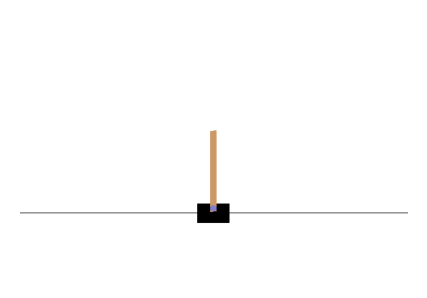

In [18]:
%%time

ret = view.view(interval=10)

In [19]:
HTML(ret)  # should be placed in another cell

In [20]:
env.close()